In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [64]:
df = pd.read_csv(r"E:\ny_housing_project\notebooks\price_house_clean.csv")
df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,PROPERTYM2,BOROUGH,price_outlier,BEDS_GROUP,BATH_GROUP,NEEDS_MANUAL_CHECK,PRICE_PER_SQM,Price_Segment
0,douglas elliman,condo,315000,2,2,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,130.064200,Manhattan,False,2,2,True,2421.880887,Low
1,serhant,condo,195000000,7,10,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991,1629.983135,Manhattan,True,7,10,True,119633.139640,High
2,sowae corp,house,260000,4,2,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,187.199545,Staten Island,False,4,2,True,1388.892265,Low
3,compass,condo,69000,3,1,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,41.341835,Manhattan,False,3,1,True,1669.011547,Low
4,sotheby's,townhouse,55000000,7,2,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,1316.900025,Manhattan,True,7,2,True,41764.749758,High


In [65]:
df1 = df.drop(columns =['Price_Segment','NEEDS_MANUAL_CHECK','BATH_GROUP','BEDS_GROUP','BROKERTITLE','PRICE_PER_SQM','FORMATTED_ADDRESS'])
df1

,TYPE,PRICE,BEDS,BATH,LATITUDE,LONGITUDE,PROPERTYM2,BOROUGH,price_outlier
0,condo,315000,2,2,40.761255,-73.974483,130.064200,Manhattan,False
1,condo,195000000,7,10,40.766393,-73.980991,1629.983135,Manhattan,True
2,house,260000,4,2,40.541805,-74.196109,187.199545,Staten Island,False
3,condo,69000,3,1,40.761398,-73.974613,41.341835,Manhattan,False
4,townhouse,55000000,7,2,40.767224,-73.969856,1316.900025,Manhattan,True
...,...,...,...,...,...,...,...,...,...
4226,multi family home,2300000,3,3,40.598830,-73.985964,218.786565,Manhattan,False
4227,multi family home,799000,6,2,40.902780,-73.854059,185.806000,Bronx,False
4228,multi family home,1380000,12,3,40.712448,-73.800851,249.072943,Queens,False
4229,multi family home,1700000,3,7,40.651222,-74.005780,729.660162,Brooklyn,False


In [66]:
df['PRICE'].skew()

np.float64(16.33178965230022)

In [67]:
display(df.describe())  # Xem min/max/mean để phát hiện outlier


,PRICE,BEDS,BATH,LATITUDE,LONGITUDE,PROPERTYM2,BEDS_GROUP,BATH_GROUP,PRICE_PER_SQM
count,4.231000e+03,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000
mean,1.967231e+06,3.375561,2.364689,40.716921,-73.937945,203.417850,3.268022,2.320492,8545.566263
std,5.132185e+06,2.690858,2.015794,0.086919,0.098227,217.885940,1.993611,1.568259,13072.401181
min,4.950000e+04,1.000000,0.000000,40.499798,-74.253033,23.225750,1.000000,0.000000,369.604763
25%,4.980000e+05,2.000000,1.000000,40.643480,-73.984988,111.483600,2.000000,1.000000,3498.596276
50%,8.380000e+05,3.000000,2.000000,40.729150,-73.947266,202.919463,3.000000,2.000000,5361.733093
75%,1.500000e+06,4.000000,3.000000,40.773565,-73.867658,202.919463,4.000000,3.000000,8993.519755
max,1.950000e+08,50.000000,50.000000,40.912729,-73.702450,6088.398105,10.000000,10.000000,295683.810276


In [68]:
df_outlier= df.query("price_outlier == True")
df_normal = df.query("price_outlier == False")

df_outlier.describe()

,PRICE,BEDS,BATH,LATITUDE,LONGITUDE,PROPERTYM2,BEDS_GROUP,BATH_GROUP,PRICE_PER_SQM
count,4.880000e+02,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000,488.000000
mean,1.002481e+07,5.153689,4.442623,40.745275,-73.976363,440.939266,4.620902,4.161885,29134.925577
std,1.233265e+07,4.829638,3.813516,0.048809,0.037969,523.447179,2.073033,2.199594,29785.845854
min,3.099000e+06,1.000000,0.000000,40.525422,-74.166603,119.194549,1.000000,0.000000,1134.201320
25%,4.093750e+06,3.000000,2.000000,40.721347,-73.997818,202.919463,3.000000,2.000000,15672.362335
50%,6.297500e+06,4.000000,4.000000,40.751647,-73.978614,282.889635,4.000000,4.000000,21327.318296
75%,1.119375e+07,6.000000,5.000000,40.775161,-73.963525,485.720110,6.000000,5.000000,32037.091266
max,1.950000e+08,50.000000,50.000000,40.898508,-73.740176,6088.398105,10.000000,10.000000,295683.810276


In [69]:
df_normal.describe()

,PRICE,BEDS,BATH,LATITUDE,LONGITUDE,PROPERTYM2,BEDS_GROUP,BATH_GROUP,PRICE_PER_SQM
count,3.743000e+03,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000
mean,9.167109e+05,3.143735,2.093775,40.713224,-73.932936,172.450591,3.091638,2.080417,5861.193476
std,6.397494e+05,2.164079,1.436718,0.090065,0.102478,98.436547,1.914080,1.284783,3900.992179
min,4.950000e+04,1.000000,1.000000,40.499798,-74.253033,23.225750,1.000000,1.000000,369.604763
25%,4.490000e+05,2.000000,1.000000,40.634777,-73.981494,102.193300,2.000000,1.000000,3326.442866
50%,7.490000e+05,3.000000,2.000000,40.724424,-73.936992,200.670480,3.000000,2.000000,4858.208218
75%,1.200000e+06,4.000000,2.000000,40.772306,-73.858593,202.919463,4.000000,2.000000,7365.239752
max,3.000000e+06,24.000000,32.000000,40.912729,-73.702450,1950.963000,10.000000,10.000000,32035.461462


In [79]:
numeric_features = ['BEDS', 'BATH', 'PROPERTYM2']
categorical_features = ['TYPE', 'BOROUGH']

In [106]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])
pipelines = {
    "Linear": Pipeline([("preprocessor", preprocessor), ("regressor", LinearRegression())]),
    "Lasso": Pipeline([("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.1))]),
    "Ridge": Pipeline([("preprocessor", preprocessor), ("regressor", Ridge(alpha=1.0))]),
    "RandomForest": Pipeline([("preprocessor", preprocessor), ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))]),
    "GradientBoosting": Pipeline([("preprocessor", preprocessor), ("regressor", GradientBoostingRegressor(n_estimators=100, random_state=42))]),
    "SVR": Pipeline([("preprocessor", preprocessor), ("regressor", SVR(kernel='rbf'))])
}



In [110]:
# Mainstream
X_normal = df_normal[numeric_features + categorical_features]
y_normal = np.log(df_normal['PRICE'])

Xn_train, Xn_test, yn_train, yn_test = train_test_split( X_normal, y_normal, test_size=0.2, random_state=42)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

results = []

for name, pipe in pipelines.items():
    pipe.fit(Xn_train, yn_train)
    y_pred = pipe.predict(Xn_test)
    rmse = np.sqrt(mean_squared_error(yn_test, y_pred))
    r2 = r2_score(yn_test, y_pred)
    results.append((name, rmse, r2))
    y_pred_train = pipe.predict(Xn_train)
    y_pred_test = pipe.predict(Xn_test)
# In kết quả
for name, rmse, r2 in results:
    print(f"{name:<15} RMSE: {rmse:.3f}, R²: {r2:.3f}")


Linear          RMSE: 0.466, R²: 0.563
Lasso           RMSE: 0.595, R²: 0.288
Ridge           RMSE: 0.466, R²: 0.563
RandomForest    RMSE: 0.418, R²: 0.648
GradientBoosting RMSE: 0.403, R²: 0.673
SVR             RMSE: 0.390, R²: 0.693


In [114]:
r2_train = r2_score(yn_train, y_pred_train)
r2_test = r2_score(yn_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(yn_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(yn_test, y_pred_test))


In [117]:
a =  r2_train - r2_test 
b = rmse_test - rmse_train
print(f"R² Train: {r2_train:.3f}, R² Test: {r2_test:.3f}, Difference: {a:.3f}")
print(f"RMSE Train: {rmse_train:.3f}, RMSE Test: {rmse_test:.3f}, Difference: {b:.3f}")

R² Train: 0.737, R² Test: 0.693, Difference: 0.043
RMSE Train: 0.369, RMSE Test: 0.390, Difference: 0.022


In [109]:
# Mainstream
X_normal = df_outlier[numeric_features + categorical_features]
y_normal = np.log(df_outlier['PRICE'])

Xn_train, Xn_test, yn_train, yn_test = train_test_split( X_normal, y_normal, test_size=0.2, random_state=42)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

results = []

for name, pipe in pipelines.items():
    pipe.fit(Xn_train, yn_train)
    y_pred = pipe.predict(Xn_test)
    rmse = np.sqrt(mean_squared_error(yn_test, y_pred))
    r2 = r2_score(yn_test, y_pred)
    results.append((name, rmse, r2))

# In kết quả
for name, rmse, r2 in results:
    print(f"{name:<15} RMSE: {rmse:.3f}, R²: {r2:.3f}")


Linear          RMSE: 0.646, R²: 0.286
Lasso           RMSE: 0.744, R²: 0.053
Ridge           RMSE: 0.645, R²: 0.288
RandomForest    RMSE: 0.551, R²: 0.480
GradientBoosting RMSE: 0.517, R²: 0.543
SVR             RMSE: 0.507, R²: 0.560


In [ ]:
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


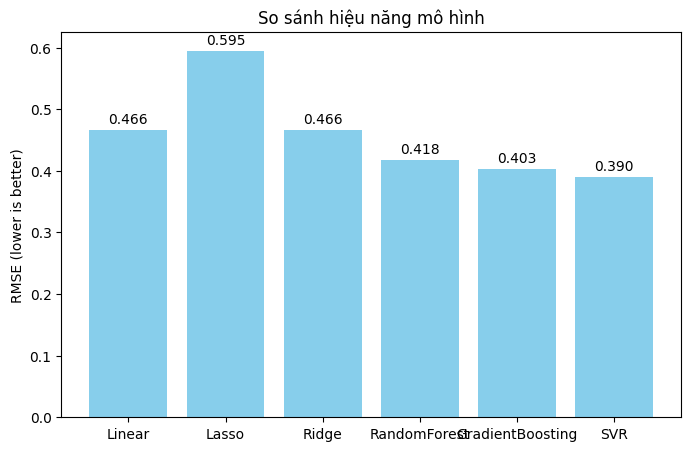

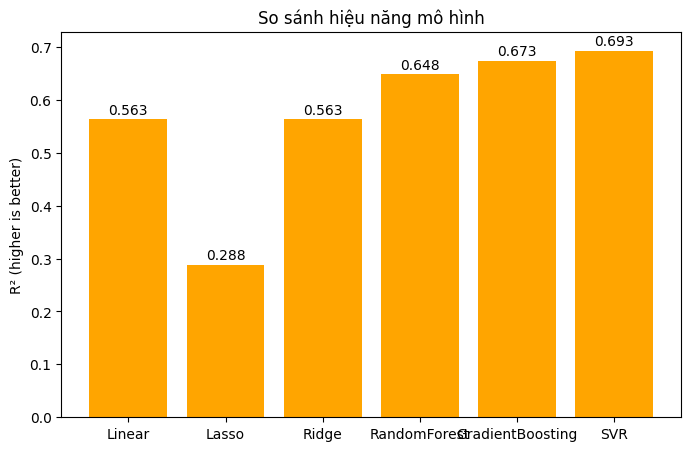

In [108]:
import matplotlib.pyplot as plt

names = ["Linear", "Lasso", "Ridge", "RandomForest", "GradientBoosting", "SVR"]
rmse = [0.466, 0.595, 0.466, 0.418, 0.403, 0.390]
r2 =   [0.563, 0.288, 0.563, 0.648, 0.673, 0.693]

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.bar(names, rmse, color='skyblue')
ax1.set_ylabel("RMSE (lower is better)")
ax1.set_title("So sánh hiệu năng mô hình")

for i,v in enumerate(rmse):
    ax1.text(i, v+0.01, f"{v:.3f}", ha='center')

plt.show()

plt.figure(figsize=(8,5))
plt.bar(names, r2, color='orange')
plt.ylabel("R² (higher is better)")
plt.title("So sánh hiệu năng mô hình")
for i,v in enumerate(r2):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.show()


In [ ]:

# Luxury
X_lux = df_outlier[numeric_features + categorical_features]
y_lux = np.log(df_outlier['PRICE'])

Xl_train, Xl_test, yl_train, yl_test = train_test_split( X_lux, y_lux, test_size=0.2, random_state=42)

pipeline_luxury.fit(Xl_train, yl_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [89]:

# Predict trên test set (log scale)
y_pred_log = pipeline_normal.predict(Xn_test)

# Chuyển về giá gốc
y_pred = np.exp(y_pred_log)
y_true = np.exp(yn_test)

# Tính RMSE và R²
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"[Mainstream] RMSE: {rmse:,.0f}, R²: {r2:.3f}")


[Mainstream] RMSE: 552,364, R²: 0.207


In [ ]:
# Predict trên test set (log scale)
y_pred_log_lux = pipeline_luxury.predict(Xl_test)

# Chuyển về giá gốc
y_pred_lux = np.exp(y_pred_log_lux)
y_true_lux = np.exp(yl_test)

# Tính RMSE và R²
rmse_lux = np.sqrt(mean_squared_error(y_true_lux, y_pred_lux))
r2_lux = r2_score(y_true_lux, y_pred_lux)

print(f"[Luxury] RMSE: {rmse_lux:,.0f}, R²: {r2_lux:.3f}")


[Luxury] RMSE: 17,983,269, R²: 0.261
